In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

overlap_thresholds = [0.1, 0.2, 0.5]
channels = ['EEG F3-A2', 'EEG F4-A1', 'EEG C3-A2', 'EEG C4-A1']

# load sleep stages

In [2]:
pred_path = '../../output/annotations/nikitin/pred_sleep_stages/'
pred_files = glob.glob(pred_path + '*sleepstages.txt')

gt_path = '../../output/annotations/nikitin/gt_sleep_stages/'
gt_files = glob.glob(gt_path + '*.txt')

pred_ids = [f.split('/')[-1].split('_')[0] for f in pred_files]
gt_ids = [f.split('/')[-1].split('_')[0] for f in gt_files]

unq_ids = list(set(pred_ids) & set(gt_ids))
pred_stages_all = {}
gt_stages_all = {}

for f_id in sorted(unq_ids, key=lambda x: int(x[1:])):
    pred_file = [f for f in pred_files if f_id + '_' in f][0]
    gt_file = [f for f in gt_files if f_id + '_' in f][0]

    with open(pred_file, 'r') as f:
        pred_stages = f.read().split(' ')
    pred_stages = [int(s) for s in pred_stages if s != '']
    pred_stages = [s if s != 5 else 4 for s in pred_stages]

    with open(gt_file, 'r') as f:
        gt_stages = f.read().split(' ')
    gt_stages = [int(s) for s in gt_stages if s != '']
    gt_stages = [s if s != 5 else 4 for s in gt_stages]

    pred_stages_all[f_id] = pred_stages
    gt_stages_all[f_id] = gt_stages

# shared functions

In [3]:
def overlap(spindles, sleepstages):
    sleepstages = np.repeat(sleepstages, 2)  # transform sleepstages to half epoches
    sleepstages = sleepstages == 2
    spindle_centers = (spindles[:, :2].sum(axis=1) // 2).astype(int)
    if len(sleepstages) < max(spindle_centers) // 15:
        print(f'Warning: sleepstages shorter than spindles, '
              f'ignoring {sum(spindle_centers // 15 >= len(sleepstages))} spindles')
    idx = [sleepstages[center // 15]
           if center // 15 < len(sleepstages) else False
           for center in spindle_centers]

    print(f'Warning: ignoring {sum(~np.array(idx))} spindles')

    return spindles[idx]


def calc_tp_fp_fn(gt_spindles, pred_spindles, spindle_thresholds):
    tp, fp = [0] * len(spindle_thresholds), [0] * len(spindle_thresholds)

    used_spindles = [np.zeros(len(gt_spindles)) for _ in range(len(spindle_thresholds))]
    gt_start = 0
    for pred_s in pred_spindles:
        intersects = [0] * len(gt_spindles)
        unions = [0] * len(gt_spindles)
        for gt_i in range(gt_start, len(gt_spindles)):
            gt_s = gt_spindles[gt_i]
            if pred_s[1] < gt_s[0]:
                break
            if pred_s[0] > gt_s[1]:
                gt_start = gt_i + 1
                continue
            intersects[gt_i] = min(gt_s[1], pred_s[1]) - max(gt_s[0], pred_s[0])
            unions[gt_i] = max(gt_s[1], pred_s[1]) - min(gt_s[0], pred_s[0])
        ious = [intersects[i] / unions[i] if unions[i] > 0 else 0
                for i in range(len(intersects))]
        for i, spindle_threshold in enumerate(spindle_thresholds):
            if len(ious) > 0 and max(ious) > spindle_threshold:
                tp[i] += 1
                used_spindles[i][np.argmax(ious)] = 1
            else:
                fp[i] += 1

    fn = [len(gt_spindles) - np.sum(used_spindles[i]) for i in range(len(spindle_thresholds))]

    return tp, fp, fn


def merge_and_filter_spindles(spindles, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    sort_idx = np.argsort(spindles[:, 0])
    spindles = spindles[sort_idx]
    durations = np.diff(spindles, axis=1).squeeze()
    distances = spindles[1:, 0] - spindles[:-1, 1]
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindles[np.r_[to_merge, False], 1] = spindles[np.r_[False, to_merge], 1]
    spindles = spindles[~np.r_[False, to_merge]]

    durations = np.diff(spindles, axis=1).squeeze()
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindles = spindles[~to_filter]

    if np.sum(to_merge) > 0 or np.sum(to_filter) > 0:
        print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindles

# load spindles

In [4]:
pred_path_gt_stages = '../../output/annotations/nikitin/pred_spindles_w_gt_stages/'
pred_files_gt_stages = glob.glob(pred_path_gt_stages + "*.npz")

gt_path = '../../output/annotations/nikitin/gt_spindles/combined_spindles.npz'
gt_data = np.load(gt_path)

pred_ids = [f.split('/')[-1].split('_')[0] for f in pred_files_gt_stages]
gt_ids = [f.split('_')[0] for f in gt_data.keys()]
unq_ids = list(set(pred_ids) & set(gt_ids))

gt_data = {f_id: gt_data[f"{f_id}_EEG F3-A2"] for f_id in unq_ids}

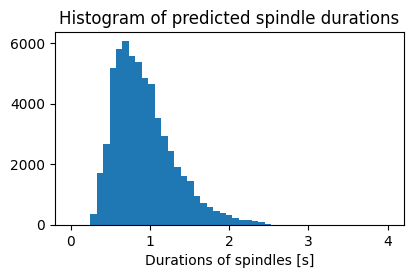

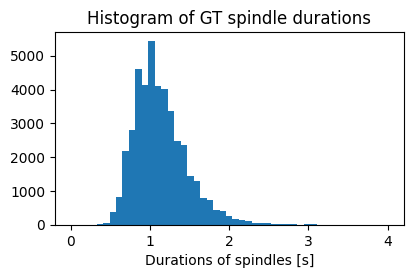

In [5]:
pred_spindles_agg_gt_stages = {}
for f in pred_files_gt_stages:
    f_id = f.split('/')[-1].split('_')[0]
    pred_spindles_agg_gt_stages[f_id] = np.load(f)[f"{f_id}_{channels[0]}_fold-0_agg"]

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of predicted spindle durations')
plt.hist(np.concatenate([np.diff(s[:, :2]) for s in pred_spindles_agg_gt_stages.values()]), bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of GT spindle durations')
plt.hist(np.concatenate([np.diff(s[:, :2]) for s in gt_data.values()]), bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

# compare predicted spindles filtered with GT sleep stages to expert

In [6]:
f1_scores = {ovt: {} for ovt in overlap_thresholds}
precision_scores = {ovt: {} for ovt in overlap_thresholds}
recall_scores = {ovt: {} for ovt in overlap_thresholds}

total_tp = {ovt: 0 for ovt in overlap_thresholds}
total_fp = {ovt: 0 for ovt in overlap_thresholds}
total_fn = {ovt: 0 for ovt in overlap_thresholds}
for f_id in sorted(unq_ids, key=lambda x: int(x[1:])):
    gt_sleep_stages = gt_stages_all[f_id]
    gt_spindles = gt_data[f_id][:, :2]
    pred_spindles = pred_spindles_agg_gt_stages[f_id][:, :2]

    spindles_filtered = overlap(pred_spindles, gt_sleep_stages)
    spindles_filtered = merge_and_filter_spindles(spindles_filtered)
    gt_data_filtered = overlap(gt_spindles, gt_sleep_stages)
    # gt_data_filtered = merge_and_filter_spindles(gt_data_filtered)

    tp, fp, fn = calc_tp_fp_fn(gt_data_filtered, spindles_filtered, overlap_thresholds)

    for i, ov_thresh in enumerate(overlap_thresholds):
        total_tp[ov_thresh] += tp[i]
        total_fp[ov_thresh] += fp[i]
        total_fn[ov_thresh] += fn[i]

        prec = tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] > 0 else 1
        rec = tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] > 0 else 1
        f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        print(
            f'File {f_id}, overlap threshold: {ov_thresh}, #spindles pred: {len(spindles_filtered)}, '
            f'#spindles gt: {len(gt_data_filtered)}, spindle frac: {len(spindles_filtered) / len(gt_data_filtered):.2f}, '
            f'prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')
        f1_scores[ov_thresh][f_id] = f1
        precision_scores[ov_thresh][f_id] = prec
        recall_scores[ov_thresh][f_id] = rec

File -, overlap threshold: 0.1, #spindles pred: 1088, #spindles gt: 385, spindle frac: 2.83, prec: 0.347, rec: 0.972, f1: 0.512
File -, overlap threshold: 0.2, #spindles pred: 1088, #spindles gt: 385, spindle frac: 2.83, prec: 0.346, rec: 0.972, f1: 0.510
File -, overlap threshold: 0.5, #spindles pred: 1088, #spindles gt: 385, spindle frac: 2.83, prec: 0.325, rec: 0.919, f1: 0.481
File -, overlap threshold: 0.1, #spindles pred: 1578, #spindles gt: 592, spindle frac: 2.67, prec: 0.366, rec: 0.975, f1: 0.532
File -, overlap threshold: 0.2, #spindles pred: 1578, #spindles gt: 592, spindle frac: 2.67, prec: 0.366, rec: 0.975, f1: 0.532
File -, overlap threshold: 0.5, #spindles pred: 1578, #spindles gt: 592, spindle frac: 2.67, prec: 0.349, rec: 0.931, f1: 0.508
File -, overlap threshold: 0.1, #spindles pred: 1954, #spindles gt: 608, spindle frac: 3.21, prec: 0.308, rec: 0.990, f1: 0.470
File -, overlap threshold: 0.2, #spindles pred: 1954, #spindles gt: 608, spindle frac: 3.21, prec: 0.308

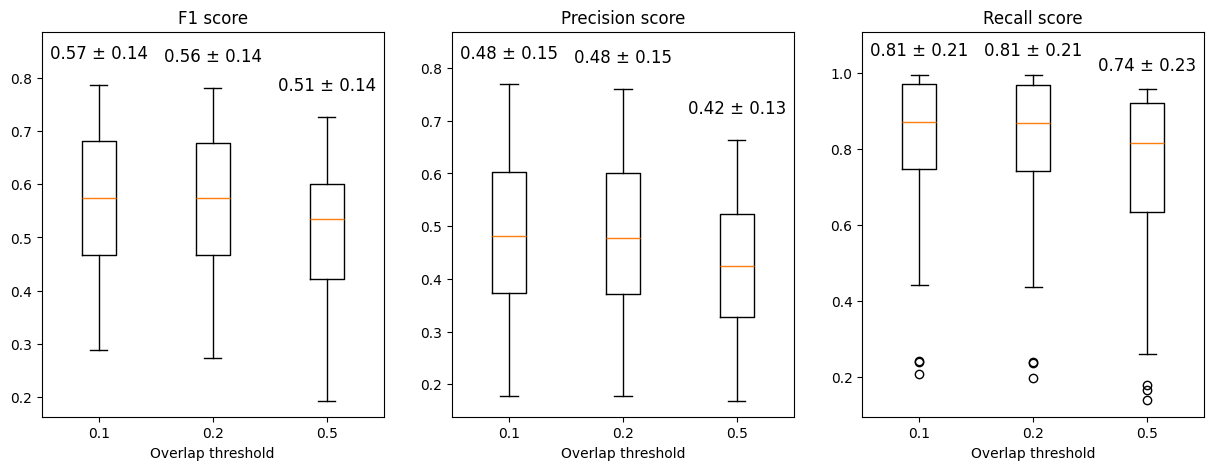

Expert centered scores:
Overlap threshold: 0.1, prec: 0.481, rec: 0.809, f1: 0.603
Overlap threshold: 0.2, prec: 0.478, rec: 0.805, f1: 0.600
Overlap threshold: 0.5, prec: 0.434, rec: 0.736, f1: 0.546


In [7]:
# plot f1 scores as boxplot
def plot_scores(f1_scores, precision_scores, recall_scores):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    f1_scores_to_plot = [np.array(list(f1_scores[k].values())) for k in f1_scores.keys()]
    bps = plt.boxplot(f1_scores_to_plot)
    for i in range(len(f1_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{f1_scores_to_plot[i].mean():.2f} ± {f1_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(f1_scores.keys()) + 1), f1_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('F1 score')

    plt.subplot(1, 3, 2)
    precision_scores_to_plot = [np.array(list(precision_scores[k].values())) for k in precision_scores.keys()]
    bps = plt.boxplot(precision_scores_to_plot)
    for i in range(len(precision_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{precision_scores_to_plot[i].mean():.2f} ± {precision_scores_to_plot[i].std():.2f}", size=12,
                 ha="center")
    plt.xticks(range(1, len(precision_scores.keys()) + 1), precision_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('Precision score')

    plt.subplot(1, 3, 3)
    recall_scores_to_plot = [np.array(list(recall_scores[k].values())) for k in recall_scores.keys()]
    bps = plt.boxplot(recall_scores_to_plot)
    for i in range(len(recall_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{recall_scores_to_plot[i].mean():.2f} ± {recall_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(recall_scores.keys()) + 1), recall_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.title('Recall score')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.show()


plot_scores(f1_scores, precision_scores, recall_scores)

print('Expert centered scores:')
for i, ov_thresh in enumerate(overlap_thresholds):
    prec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fp[ov_thresh]) if total_tp[ov_thresh] + total_fp[
        ov_thresh] > 0 else 1
    rec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fn[ov_thresh]) if total_tp[ov_thresh] + total_fn[
        ov_thresh] > 0 else 1
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    print(f'Overlap threshold: {ov_thresh}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')

# compare predicted spindles filtered with RSN sleep stages to expert

In [8]:
pred_path_pred_all_ch = '../../output/annotations/nikitin/pred_spindles_w_pred_stages/'
pred_files_pred_all_ch = glob.glob(pred_path_pred_all_ch + "*.npz")

pred_ids = [f.split('/')[-1].split('_')[0] for f in pred_files_gt_stages]
assert len(set(pred_ids)) == len(
    set(unq_ids)), f'mismatches: {set(pred_ids) - set(unq_ids)}, {set(unq_ids) - set(pred_ids)}'

pred_spindles_agg_all_ch = {}
for f in pred_files_pred_all_ch:
    f_id = f.split('/')[-1].split('_')[0]
    pred_spindles_agg_all_ch[f_id] = np.load(f)[f"{f_id}_{channels[0]}_fold-0_agg"]


In [9]:
f1_scores = {ovt: {} for ovt in overlap_thresholds}
precision_scores = {ovt: {} for ovt in overlap_thresholds}
recall_scores = {ovt: {} for ovt in overlap_thresholds}

total_tp = {ovt: 0 for ovt in overlap_thresholds}
total_fp = {ovt: 0 for ovt in overlap_thresholds}
total_fn = {ovt: 0 for ovt in overlap_thresholds}
for f_id in sorted(unq_ids, key=lambda x: int(x[1:])):
    gt_sleep_stages = gt_stages_all[f_id]
    pred_sleep_stages = pred_stages_all[f_id]
    gt_spindles = gt_data[f_id][:, :2]
    pred_spindles = pred_spindles_agg_all_ch[f_id][:, :2]

    spindles_filtered = overlap(pred_spindles, pred_sleep_stages)
    spindles_filtered = merge_and_filter_spindles(spindles_filtered)
    gt_data_filtered = overlap(gt_spindles, gt_sleep_stages)
    # gt_data_filtered = merge_and_filter_spindles(gt_data_filtered)

    tp, fp, fn = calc_tp_fp_fn(gt_data_filtered, spindles_filtered, overlap_thresholds)

    for i, ov_thresh in enumerate(overlap_thresholds):
        total_tp[ov_thresh] += tp[i]
        total_fp[ov_thresh] += fp[i]
        total_fn[ov_thresh] += fn[i]

        prec = tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] > 0 else 1
        rec = tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] > 0 else 1
        f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        print(
            f'File {f_id}, overlap threshold: {ov_thresh}, #spindles pred: {len(spindles_filtered)}, '
            f'#spindles gt: {len(gt_data_filtered)}, spindle frac: {len(spindles_filtered) / len(gt_data_filtered):.2f}, '
            f'prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')
        f1_scores[ov_thresh][f_id] = f1
        precision_scores[ov_thresh][f_id] = prec
        recall_scores[ov_thresh][f_id] = rec

File -, overlap threshold: 0.1, #spindles pred: 1140, #spindles gt: 385, spindle frac: 2.96, prec: 0.311, rec: 0.913, f1: 0.464
File -, overlap threshold: 0.2, #spindles pred: 1140, #spindles gt: 385, spindle frac: 2.96, prec: 0.310, rec: 0.912, f1: 0.462
File -, overlap threshold: 0.5, #spindles pred: 1140, #spindles gt: 385, spindle frac: 2.96, prec: 0.289, rec: 0.855, f1: 0.431
File -, overlap threshold: 0.1, #spindles pred: 1887, #spindles gt: 592, spindle frac: 3.19, prec: 0.303, rec: 0.965, f1: 0.461
File -, overlap threshold: 0.2, #spindles pred: 1887, #spindles gt: 592, spindle frac: 3.19, prec: 0.303, rec: 0.965, f1: 0.461
File -, overlap threshold: 0.5, #spindles pred: 1887, #spindles gt: 592, spindle frac: 3.19, prec: 0.287, rec: 0.914, f1: 0.436
File -, overlap threshold: 0.1, #spindles pred: 2055, #spindles gt: 608, spindle frac: 3.38, prec: 0.292, rec: 0.987, f1: 0.451
File -, overlap threshold: 0.2, #spindles pred: 2055, #spindles gt: 608, spindle frac: 3.38, prec: 0.292

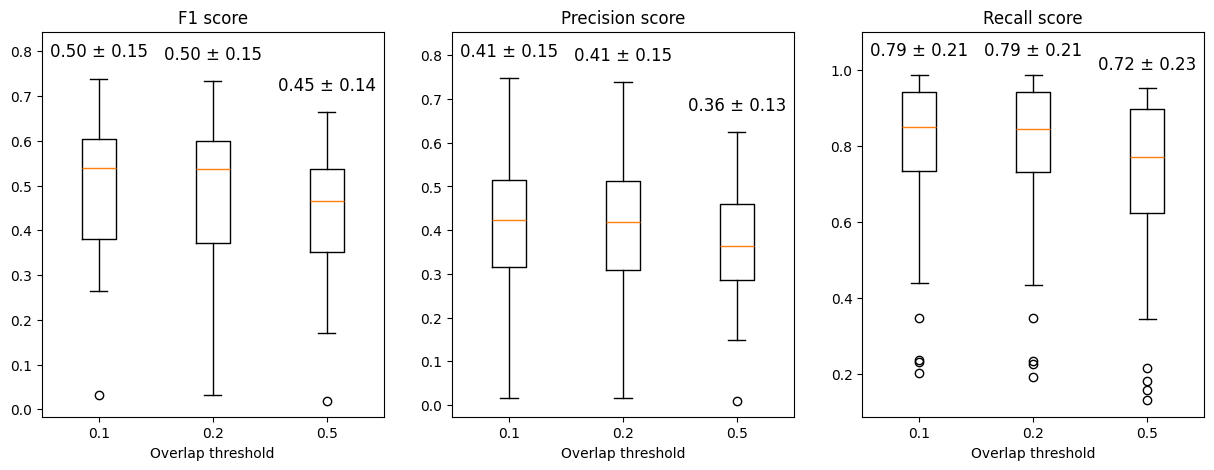

Expert centered scores:
Overlap threshold: 0.1, prec: 0.411, rec: 0.794, f1: 0.542
Overlap threshold: 0.2, prec: 0.408, rec: 0.791, f1: 0.538
Overlap threshold: 0.5, prec: 0.371, rec: 0.723, f1: 0.490


In [10]:
plot_scores(f1_scores, precision_scores, recall_scores)

print('Expert centered scores:')
for i, ov_thresh in enumerate(overlap_thresholds):
    prec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fp[ov_thresh]) if total_tp[ov_thresh] + total_fp[
        ov_thresh] > 0 else 1
    rec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fn[ov_thresh]) if total_tp[ov_thresh] + total_fn[
        ov_thresh] > 0 else 1
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    print(f'Overlap threshold: {ov_thresh}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')